# 📈 Reliance Stock Market Prediction

**Notebook pattern:** Follows the step-by-step structure of `diabetes_prediction.ipynb` (imports, data load, EDA, preprocessing, training, evaluation, saving `.pkl`, loading and sample prediction).

**What this notebook does:**
- Takes **user input** for stock symbol, start date, and end date.
- Downloads historical data from Yahoo Finance (using `yfinance`).
- Performs EDA and feature engineering (moving averages, returns).
- Trains a regression model to predict the **next day's Close** price.
- Saves the trained model and scaler as `.pkl` files and demonstrates loading them.

**Notes:**
- Run this notebook in an environment with internet access (e.g., local Jupyter, Colab) for `yfinance` to fetch data.
- If running in Google Colab, the download cell will trigger browser downloads.


## 1) Import libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# optional: yfinance for fetching stock data
try:
    import yfinance as yf
except Exception as e:
    print('yfinance not available. Install with `pip install yfinance` if you want to fetch data from Yahoo Finance.')

# display settings
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (12,6)


In [7]:
# 2) User inputs: stock symbol and date range
print('Enter the stock symbol and date range (YYYY-MM-DD). Example for Reliance on NSE: RELIANCE.NS')

stock_symbol = input('Stock symbol (e.g., RELIANCE.NS): ').strip()
start_date = input('Start date (YYYY-MM-DD): ').strip()
end_date = input('End date (YYYY-MM-DD): ').strip()

# Provide simple defaults if user leaves blank
if stock_symbol == '':
    stock_symbol = 'RELIANCE.NS'
if start_date == '':
    start_date = '2023-01-01'
if end_date == '':
    end_date = datetime.today().strftime('%Y-%m-%d')

print(f"Using: {stock_symbol} from {start_date} to {end_date}")


Enter the stock symbol and date range (YYYY-MM-DD). Example for Reliance on NSE: RELIANCE.NS


Stock symbol (e.g., RELIANCE.NS):  RELIANCE.NS
Start date (YYYY-MM-DD):  2025-08-01
End date (YYYY-MM-DD):  2025-08-12


Using: RELIANCE.NS from 2025-08-01 to 2025-08-12


In [8]:
# 3) Fetch historical stock data from Yahoo Finance
try:
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    if df.empty:
        raise ValueError('Downloaded DataFrame is empty. Check symbol/date range or your internet connection.')
    df.reset_index(inplace=True)
    display(df.head())
    print('\nDownloaded rows:', len(df))
except Exception as e:
    print('Error fetching data with yfinance:', e)
    print('\nIf you already have a CSV, you can load it instead by setting `df = pd.read_csv("your_file.csv")`')
    df = pd.DataFrame()


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
0,2025-08-01,1393.699951,1405.900024,1384.300049,1386.900024,10321171
1,2025-08-04,1411.500000,1416.099976,1391.699951,1395.099976,6312820
2,2025-08-05,1391.699951,1411.000000,1388.099976,1411.000000,9315972
3,2025-08-06,1392.800049,1395.900024,1383.300049,1391.900024,5834312
4,2025-08-07,1389.400024,1393.699951,1366.000000,1387.699951,9976705



Downloaded rows: 7


In [9]:
# 4) Basic EDA: info, describe, missing values
if not df.empty:
    display(df.info())
    display(df.describe())
    print('\nMissing values per column:')
    display(df.isnull().sum())
else:
    print('No dataframe available for EDA.')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   (Date, )               7 non-null      datetime64[ns]
 1   (Close, RELIANCE.NS)   7 non-null      float64       
 2   (High, RELIANCE.NS)    7 non-null      float64       
 3   (Low, RELIANCE.NS)     7 non-null      float64       
 4   (Open, RELIANCE.NS)    7 non-null      float64       
 5   (Volume, RELIANCE.NS)  7 non-null      int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 468.0 bytes


None

Price,Date,Close,High,Low,Open,Volume
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
count,7,7.000000,7.000000,7.000000,7.000000,7.000000e+00
mean,2025-08-06 00:00:00,1390.442854,1401.114275,1377.085711,1389.657139,8.650296e+06
min,2025-08-01 00:00:00,1367.800049,1388.000000,1361.199951,1370.000000,5.834312e+06
25%,2025-08-04 12:00:00,1387.799988,1394.799988,1365.500000,1385.950012,7.553213e+06
50%,2025-08-06 00:00:00,1391.699951,1397.199951,1383.300049,1387.699951,9.315972e+06
75%,2025-08-07 12:00:00,1393.250000,1408.450012,1386.200012,1393.500000,9.987096e+06
max,2025-08-11 00:00:00,1411.500000,1416.099976,1391.699951,1411.000000,1.032117e+07
std,NaN,12.864260,10.121503,12.562308,12.313252,1.835907e+06



Missing values per column:


Price   Ticker     
Date                   0
Close   RELIANCE.NS    0
High    RELIANCE.NS    0
Low     RELIANCE.NS    0
Open    RELIANCE.NS    0
Volume  RELIANCE.NS    0
dtype: int64

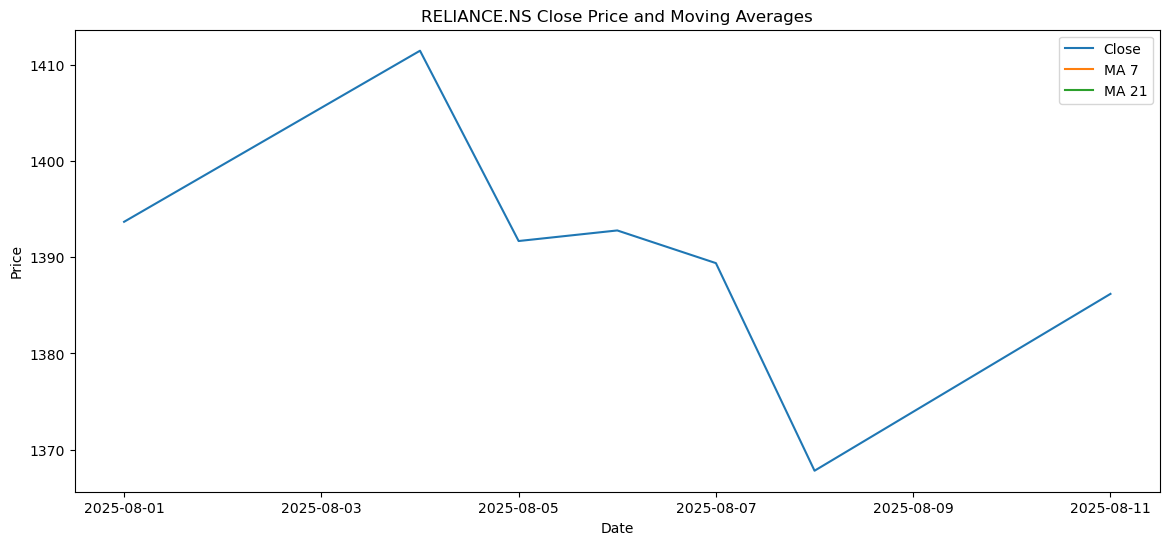

In [10]:
# 5) Plot Close price and moving averages
if not df.empty:
    df['MA7'] = df['Close'].rolling(window=7).mean()
    df['MA21'] = df['Close'].rolling(window=21).mean()
    df['Daily_Return'] = df['Close'].pct_change()

    plt.figure(figsize=(14,6))
    plt.plot(df['Date'], df['Close'], label='Close')
    plt.plot(df['Date'], df['MA7'], label='MA 7')
    plt.plot(df['Date'], df['MA21'], label='MA 21')
    plt.title(f'{stock_symbol} Close Price and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
else:
    print('No dataframe available to plot.')


In [11]:
# 6) Feature engineering: create features and the target (next day's Close)
if not df.empty:
    # Create moving averages and returns (again, to be safe)
    df['MA7'] = df['Close'].rolling(window=7).mean()
    df['MA21'] = df['Close'].rolling(window=21).mean()
    df['Daily_Return'] = df['Close'].pct_change()

    # Shift Close to create target (predict next day's Close)
    df['Target'] = df['Close'].shift(-1)

    # Drop rows with NaN produced by rolling/shift
    df_features = df.dropna().copy()

    # Choose features used for prediction
    feature_cols = ['Open', 'High', 'Low', 'Volume', 'MA7', 'MA21', 'Daily_Return']
    X = df_features[feature_cols]
    y = df_features['Target']

    print('Feature matrix shape:', X.shape)
    print('Target vector shape:', y.shape)
else:
    print('No dataframe available for feature engineering.')


Feature matrix shape: (0, 7)
Target vector shape: (0,)


In [12]:
# 7) Train-test split and scaling
if not df.empty:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print('X_train_scaled shape:', X_train_scaled.shape)
else:
    print('No data to train on.')


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [13]:
# 8) Train the model (Random Forest Regressor)
if not df.empty:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    print('Model training completed.')
else:
    print('No data to train model.')


NameError: name 'X_train_scaled' is not defined

In [ ]:
# 9) Evaluate model on test set
if not df.empty:
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')

    # Plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(df_features['Date'].iloc[-len(y_test):], y_test.values, label='Actual (Next Close)')
    plt.plot(df_features['Date'].iloc[-len(y_test):], y_pred, label='Predicted (Next Close)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title('Actual vs Predicted Close Price (Test Set)')
    plt.show()
else:
    print('No predictions to evaluate.')


In [ ]:
# 10) Save trained model and scaler to .pkl files
if not df.empty:
    model_filename = f"{stock_symbol.replace('.','_')}_stock_model.pkl"
    scaler_filename = f"{stock_symbol.replace('.','_')}_stock_scaler.pkl"
    joblib.dump(model, model_filename)
    joblib.dump(scaler, scaler_filename)
    print('Saved model to', model_filename)
    print('Saved scaler to', scaler_filename)
else:
    print('No model to save.')


In [ ]:
# 11) Load saved model and scaler, then make a sample prediction
if not df.empty:
    loaded_model = joblib.load(model_filename)
    loaded_scaler = joblib.load(scaler_filename)

    # Use the last available row's features to predict the next day's Close
    last_features = X.iloc[[-1]]  # last row in feature matrix
    last_scaled = loaded_scaler.transform(last_features)
    next_close_pred = loaded_model.predict(last_scaled)[0]

    print('Last available date in dataset:', df_features['Date'].iloc[-1])
    print('Last actual Close:', df_features['Close'].iloc[-1])
    print('Predicted next day Close (based on last row):', round(next_close_pred, 4))
else:
    print('No saved model to load.')


In [ ]:
# 12) (Optional) Save the processed dataset and provide download instructions
if not df.empty:
    processed_csv = f"{stock_symbol.replace('.','_')}_processed.csv"
    df_features.to_csv(processed_csv, index=False)
    print('Processed dataset saved to', processed_csv)

    # If running in Google Colab, trigger download
    try:
        from google.colab import files
        files.download(model_filename)
        files.download(scaler_filename)
        files.download(processed_csv)
    except Exception:
        print('\nIf you are running this locally, find the files in your working directory.')
else:
    print('No processed dataset to save.')


---

## Next steps & customization ideas

- Try different models (e.g., `GradientBoostingRegressor`, `XGBoost`, `LinearRegression`) and compare results.
- Add more features (technical indicators like RSI, MACD, Bollinger Bands).
- Use a time-series specific approach (e.g., ARIMA, Prophet, LSTM) for potentially better sequential predictions.
- Tune hyperparameters with `GridSearchCV` or `RandomizedSearchCV`.

**This notebook follows the diabetes_prediction.ipynb step-by-step pattern:** imports, input, data load, EDA, preprocessing, train/test split, scaling, training, evaluation, saving/loading `.pkl`, and sample prediction.
